## Задача 6

### Решить дифференциальное уравнение проекционными методами (задание - 2.8, стр.19, варианты - 2.9, стр.20, по второй части методички).


### Вариант 7

Граничная задача

$-\frac{4 + x}{5 + 2x}u'' + \Big(\frac{x}{2} - 1\Big)u' + (1 + e^{x/2})u = 2 + x$

$u'(-1) = u(1) + 2u'(1) = 0$


Входные данные

In [1]:
import numpy as np
from math import exp, cos, pi
from scipy.integrate import quad
from pandas import DataFrame
import matplotlib.pyplot as plt

def p(x):
    return -(4 + x) / (5 + 2 * x)

def q(x):
    return x / 2 - 1

def r(x):
    return 1 + exp(x / 2)

def f(x):
    return 2 + x

alpha_1 = 0
alpha_2 = -1
beta_1  = 1
beta_2  = 2

c1, c2 = 2, -3
d1, d2 = -11, 2

Реализации функций $P_n^{(k, k)}(x)$, $W_i(x)$, $\psi_i(x)$

In [2]:
def P_func(x: float, n: int, k: int) -> float:
    if n == 0:
        return 1.0

    if n == 1:
        return (k + 1) * x

    prev_funcs = [1.0, (k + 1) * x]
    for i in range(2, n + 1):
        prev_funcs.append(
            ((n + k + 2) * (2 * n + 2 * k + 3) * x * prev_funcs[i - 1] - (n + k + 2) * (n + k + 1) * prev_funcs[i - 2]) /
            ((n + 2 * k + 2) * (n + 2))
        )
    return prev_funcs[n]

def W_func(x: float, i: int):
    if i == 1:
        return (x ** 2) + c1 * x + d1

    if i == 2:
        return (x ** 3) + c2 * x + d2

    return ((1 - (x ** 2)) ** 2) * P_func(x, i - 3, 2)

def W_func_derivative(x: float, i: int):
    if i == 1:
        return 2 * x + c1

    if i == 2:
        return 3 * (x ** 2) + c2

    return -2 * (i - 2) * (1 - (x ** 2)) * P_func(x, i - 2, 1)

def W_func_second_derivative(x: float, i: int) -> float:
    if i == 1:
        return 2

    if i == 2:
        return 6 * x

    return 4 * (i - 2) * (i - 1) * P_func(x, i - 1, 0)

def psi_func(x: float, i: int) -> float:
    return P_func(x, i, 0)

Реализация метода моментов

In [3]:
def moment_method(n):
    A = np.zeros((n, n))
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            A[i - 1, j - 1] = quad(lambda x: (p(x) * W_func_second_derivative(x, j) + q(x) * W_func_derivative(x, j) + r(x) * W_func(x, j)) * psi_func(x, i - 1), -1, 1)[0]
            # A[i, j] = quad(lambda x: (p(x) * W_second_derivative[j](x) + q(x) * W_derivative[j](x) + r(x) * W_funcs[j](x)) * phi_funcs[i](x), -1, 1)[0]

    F = np.zeros((n, 1))
    for i in range(1, n):
        F[i - 1, 0] = quad(lambda x: f(x) * psi_func(x, i - 1), -1, 1)[0]

    c_vector = np.linalg.solve(A, F)
    return A, c_vector

Реализация метода коллокаций

In [4]:
def coll_method(n: int):
    A = np.zeros((n, n))
    t = [cos((2 * k - 1) / (2 * n) * pi) for k in range(1, n + 1)]
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            A[i - 1, j - 1] = p(t[i - 1]) * W_func_second_derivative(t[i - 1], j) + q(t[i - 1]) * W_func_derivative(t[i - 1], j) + r(t[i - 1]) * W_func(t[i - 1], j)
    F = np.zeros((n, 1))
    for i in range(1, n + 1):
        F[i - 1, 0] = f(t[i - 1])
    c_vector = np.linalg.solve(A, F)
    return A, c_vector


Подсчет $y^n(x)$

In [5]:
def y(x: float, n: int, vector_c: np.ndarray):
    ans = 0
    for i in range(1, n + 1):
        ans += vector_c[i - 1, 0] * W_func(x, i)
    return ans

Построение таблицы для метода моментов

In [6]:
rows = []
for n in range(3, 8):
    A, vector_c = moment_method(n)
    y_left = y(-0.5, n , vector_c)
    y_middle = y(0, n, vector_c)
    y_right = y(0.5, n, vector_c)
    rows.append([n, np.linalg.cond(A, np.inf), y_left, y_middle, y_right])

df = DataFrame(rows, columns=["n", "cond(A)", "y^n(-0.5)", "y^n(0)", "y^n(0.5)"])
df

,n,cond(A),y^n(-0.5),y^n(0),y^n(0.5)
0,3,18.874160,0.933662,0.934389,1.006731
1,4,20.498177,0.912850,0.948937,0.941063
2,5,30.595912,0.909636,0.952366,0.939279
3,6,32.065899,0.905014,0.945837,0.937106
4,7,39.824563,0.907302,0.945612,0.937503


Построение таблицы для метода коллокации

In [7]:
rows = []
for n in range(3, 8):
    A, vector_c = coll_method(n)
    y_left = y(-0.5, n , vector_c)
    y_middle = y(0, n, vector_c)
    y_right = y(0.5, n, vector_c)
    rows.append([n, np.linalg.cond(A, np.inf), y_left, y_middle, y_right])

df = DataFrame(rows, columns=["n", "cond(A)", "y^n(-0.5)", "y^n(0)", "y^n(0.5)"])
df

,n,cond(A),y^n(-0.5),y^n(0),y^n(0.5)
0,3,7.275388,0.902215,0.948357,0.942861
1,4,10.795623,0.905591,0.945117,0.936109
2,5,14.674840,0.905553,0.945051,0.935564
3,6,22.575264,0.905501,0.945052,0.935511
4,7,37.145988,0.905497,0.945034,0.935508


Графики решений для $n = 7$

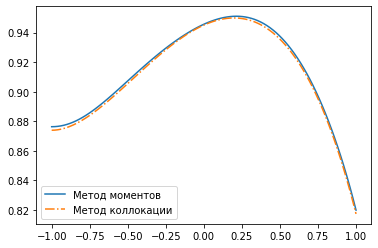

In [8]:
n = 7
_, vector_c_moment = moment_method(n)
_, vector_c_coll = coll_method(n)

x_plot = np.linspace(-1, 1, 100)
y_plot_moment = np.array([y(x, n, vector_c_moment) for x in x_plot])

y_plot_coll = np.array([y(x, n, vector_c_coll) for x in x_plot])

plt.plot(x_plot, y_plot_moment, "-", label="Метод моментов")
plt.plot(x_plot, y_plot_coll, "-.", label="Метод коллокации")
plt.legend()
plt.show()